Import Dependencies
-

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

import time
import sys

import tensorflow as tf
from tensorflow.python.keras.models import  save_model,load_model
from tensorflow.keras import layers
from deepctr.layers import custom_objects

import numpy as np
import math
from collections import deque
import random
import heapq

import scipy

Define Structure of Feature Space as a Graph
-

In [3]:
class Node:
    def __init__(self, position, distance):
        
        #Position list([row, column])
        self.position = position # [n1, n2, ..., n|N|]
        self.distance = distance #Distance for evaluation function to compare nodes in priority queue
        
  # Nodes with the same distance
    def __eq__(self, other):
        return isinstance(other, Node) and self.distance == other.distance
  
    # Node is less than other node
    def __lt__(self, other):
        return isinstance(other, Node) and self.distance < other.distance

    # Node is greater than other node
    def __gt__(self, other):
        return isinstance(other, Node) and self.distance > other.distance

Calculate Feature-Interaction Cluster
-

In [4]:
# Puts solution node into a n-way feature interaction cluster, and tell which cluster
def cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler):
    
    #print("query_node1",query_node.position, "source_node1",source_node.position)
    soln_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
                
    if tuple(soln_cluster) not in solution_clusters:
        solution_clusters[tuple(soln_cluster)] = []

    solution_clusters[tuple(soln_cluster)].append(query_node.position)
    
    return solution_clusters #returns full cluster list


def calc_feat_cluster(source_node, query_node, feat_scaler):
    
    relative_node_pos = (query_node.position - source_node.position) #Projects pos of query relative to source
    scaled_feats = (relative_node_pos * feat_scaler) #[0] #Scales features to same scale of distance
    f_max = np.argmax(abs(scaled_feats)) #Most dominant feature in solution
    soln_cluster = np.zeros(len(feat_ranges)) #Marks which feature interaction was expressed by the node position
    
    #Loop through each feature of a single solution, and determine degree of multi-feature interaction
    for f_i in range(len(scaled_feats)):
        
        if abs(scaled_feats[f_max]/scaled_feats[f_i]) <= 2:
            if scaled_feats[f_i] > 0:
                soln_cluster[f_i] = 1
            else:
                soln_cluster[f_i] = -1
    
    if scaled_feats[f_max] > 0:
        soln_cluster[f_max] = 1
    else:
        soln_cluster[f_max] = -1
        
    return soln_cluster.astype(int)

Define Synthetic Model (Global)
-
Given d-dimensional feature space, the synthetic_model() mathemtatically defines a ground truth decision boundary, such that all points within the bounds of a solution cluster are all a distance r from the source node position

Generate Uniform Distribution of Unit Vectors in d-dimensional space
-

In [6]:
def generate_unit_vectors(nfeats,nvectors=1):

    #np.random.seed(3)
    vectors = []
    for _ in range(nvectors):
        v = np.random.uniform(low=-1, high=1, size=(nfeats,))
        #v_hat = v / np.linalg.norm(v)
        vectors.append(v)
    return vectors

Find k-way Feature-Interaction Solutions Surrounding Source Node
-

In [7]:
def generate_precursor_solutions(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_prelim=20, nsteps=100):
    
    plt.rcParams["figure.figsize"] = (10,10)
    
    feat_ranges = feat_ranges #Ground truth altered boundary of solutions
    feat_range = feat_ranges[0] #debug: gti can't dynamically scale feat proportions
    feat_upscale = len(source_node.position)
    step_sizes = (feat_upscale*feat_ranges/nsteps) #How large of a step to take for each respective int feature
    feat_scaler = 1/np.asarray(feat_ranges) #Scale to normalize feature step size when calculating distance
    
    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(feat_ranges)):
        feat_steps.append(np.linspace(step_sizes[feat],step_sizes[feat]*nsteps,nsteps))
    feat_steps = np.asarray(feat_steps)
    
    source_rec = query_synth_model(source_node, source_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)

    discovered = []

    while len(discovered) < k_prelim:
        
        #print("###########################################################################")
        unit_vector = generate_unit_vectors(len(source_node.position))[0]
        unit_vector = np.sign(np.round(unit_vector)) #Scale randomly generated clusters by appropriate ratio
        for step in range(nsteps-1):
            scaled_vector_position = tuple(np.asarray(unit_vector) * np.asarray(feat_steps.T[step]) + np.asarray(source_node.position))
            #print("         ",scaled_vector_position)
            scaled_vector = Node(scaled_vector_position, None)
            query_rec = query_synth_model(source_node, scaled_vector, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
            
            #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'c+',markersize=4)
            
            if source_rec != query_rec:
                # distance heuristic
                scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
                discovered.append(scaled_vector)
                if len(discovered) % 10000 == 0:
                    print(len(discovered),end=' ')
                break
        
    return discovered #prelim_discovered

Calculate Distance from Source to Query Node
-

In [8]:
def get_distance(source_node, query_node, feat_scaler, distance='Euclidean'):
    #returns distance for ndim feature space
    
    dif = query_node.position - source_node.position
    scaled_dif = dif * feat_scaler
    
    # More efficient at scale
    if distance == 'Manhattan':
        return sum(abs(scaled_dif))
    
    if distance == 'Euclidean':
        dsum = 0
        for feat in dif:
            dsum += feat**2
        return math.sqrt(dsum)

----

Display Shortest Clusters Found During Outside-In Search
-

In [9]:
def sort_solution_clusters(solution_clusters,source_node,feat_scaler):
    
    all_distances = []
    for key in solution_clusters:
        total_distance = []
        for soln in solution_clusters[key]:
            distance = get_distance(source_node, Node(soln,None), feat_scaler)
            total_distance.append(distance)
        all_distances.append(np.sort(total_distance))
        #print(key,':',(solution_clusters[key] * np.asarray(key)).mean())
        
    sorted_clusters = []
    i = 0
    for key in solution_clusters:
        min_sample = all_distances[i].min()
        sorted_clusters.append((min_sample,key))
        i+=1
    
    sorted_clusters = np.asarray(sorted_clusters)
    ind = sorted_clusters.argsort(axis=0)
    sorted_clusters[:,0] = sorted_clusters[:,0][ind[:,0]]
    sorted_clusters[:,1] = sorted_clusters[:,1][ind[:,0]]
    
    return sorted_clusters

Adjacent Cluster Search
-

In [10]:
#Return positions in adjacent solution clusters
def find_adjs(source_node, query_node, feat_scaler):
    
    query_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
    query_cluster = list(query_cluster)
    adj_clusters = []

    #1-way changes are applied to each feature in the query cluster to generate adj clusters
    source_cluster = tuple(np.zeros(len(query_cluster)))
    for dim in range(len(query_cluster)):
        temp = query_cluster.copy()
        if temp[dim] < 1:
            temp[dim] += 1
            if temp != source_cluster:
                adj_clusters.append(temp)
        temp = query_cluster.copy()
        if temp[dim] > -1:
            temp[dim] -= 1
            if temp != source_cluster:
                adj_clusters.append(temp)

    #Normalization to find x_q
    feat_scaler_distance = 0
    for feat in feat_scaler:
        feat_scaler_distance += feat ** 2
    feat_scaler_distance = feat_scaler_distance ** 0.5
        
    adjs = []
    for cluster in adj_clusters:
        
        # n-dimensional euclidean distance to a point in the adj cluster equivalent to the distance
        # from the original query cluster
        # query_node.distance is pre-scaled scaled
        x_q = source_node.position + feat_scaler * np.asarray(cluster) * query_node.distance / feat_scaler_distance
        adj_node = Node(np.asarray(x_q), query_node.distance)
        adjs.append(adj_node)
        
    return adjs  

A* Cluster Search
-

In [11]:
#A* cluster Search
def a_star_search(source_node, prelim_discovered, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_astar=100):
    
    #Analytics to inform how to handle degree of branching
    feat_range = feat_ranges[0] #Can't yet use multiple ranges for defining gti
    nodes_generated = 0
    nodes_visited = 0
    
    frontier = [] # Priority Queue
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation
    solution_clusters = {}
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for soln_node in prelim_discovered:
        heapq.heappush(frontier, soln_node)
        nodes_generated += 1
        
    #Scale to normalize learning rate for each feature
    feat_scaler = 1/np.asarray(feat_ranges)
    
    #Opposite Recommendation as Solutions
    source_rec = query_synth_model(source_node, source_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
    # loop till queue is empty, or k solutions were discovered
    while frontier and len(discovered) < k_astar:
 
        # dequeue front node
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1
        
        #Check if query node is a solution
        query_rec = query_synth_model(source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
        if query_rec != source_rec:
            
            feat_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
            
            if tuple(feat_cluster) not in solution_clusters.keys():
                
                #Finds shortest distance node in cluster, returns solution_clusters with descending solutions
                solution_clusters, min_node = find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
                discovered.append(min_node) #redundant list
                if len(discovered) % 10 == 0:
                    print(len(discovered),end=' ')
                
                #Add adjacents to priority queue before visiting them
                adjs = find_adjs(source_node, min_node, feat_scaler) #Nodes in clusters adjacent to the current node
                for adj_node in adjs:
                    heapq.heappush(frontier, adj_node)
                    nodes_generated += 1
    
    print("\nNodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)

    return solution_clusters

In [12]:
#Return node with estimated minimum distance from source node
def find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance, nsteps=50):
    
    plt.rcParams["figure.figsize"] = (5,5)
    relative_pos = query_node.position - source_node.position
    step_sizes = (relative_pos/nsteps) #How large of a step to take for each respective int feature

    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(relative_pos)):
        if step_sizes[feat] != 0:
            feat_steps.append(np.linspace(step_sizes[feat],relative_pos[feat],nsteps))
        else:
            feat_steps.append(np.zeros(nsteps))
    for feat in feat_steps:
        np.flip(feat)
    feat_steps = np.asarray(feat_steps)    

    source_rec = query_synth_model(source_node, source_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
    query_rec = query_synth_model(source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
    if source_rec != query_rec:
        solution_clusters = cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler)
    
    min_node = query_node
    for step in range(nsteps-1):
        
        local_feat_step = []
        for feat in range(len(feat_steps)):
            local_feat_step.append(feat_steps[feat][step])
        scaled_vector_position = tuple(np.asarray(query_node.position) - np.asarray(local_feat_step))
        #scaled_vector_position = np.asarray(source_node.position + local_feat_step)
        scaled_vector = Node(scaled_vector_position, None)
        query_rec = query_synth_model(source_node, scaled_vector, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
        
        if source_rec == query_rec:
            #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'g*',markersize=20)
            break
            
        scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
        min_node = scaled_vector
        solution_clusters = cluster_feat_int(source_node, min_node, solution_clusters, feat_scaler)
        #print(min_node.position,end='')

        #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'k+',markersize=4)
        
    #print(calc_feat_cluster(source_node, min_node, feat_scaler))
    #plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=30)

    return solution_clusters, min_node

Test on Higher Dimensional Feature Space
-

In [13]:
#Individual Features with Greater Sway on the Alternate Rec Distance
def generate_continuous_gti(gti_min_cluster, feat_range, kclusters, d_dims, gti_feature_importance):
    
    #Define shortest feat cluster to build a stability descent around
    min_cluster_node = gti_min_cluster
    source_cluster = tuple(np.zeros(d_dims)) #censor in generated clusters

    frontier = []
    visited = []
    heapq.heappush(frontier, min_cluster_node)

    #Build stability descent around min_node
    i = 0
    ground_truth_importance = {}
    while frontier and i < kclusters:

        cur = heapq.heappop(frontier)
        if cur.position not in ground_truth_importance.keys():
            ground_truth_importance[cur.position] = cur.distance
            i+=1

            for dim in range(d_dims):
                temp = list(cur.position)
                if temp[dim] < 1:
                    temp[dim] += 1
                    temp = tuple(temp)
                    if temp != source_cluster and temp not in visited:
                        adj_node = Node(temp, None)
                        adj_node.distance = synth_cluster_distance_generator(min_cluster_node, adj_node, feat_range, gti_feature_importance)
                        heapq.heappush(frontier, adj_node)
                        visited.append(temp)
                
                temp = list(cur.position)
                if temp[dim] > -1:
                    temp[dim] -= 1
                    temp = tuple(temp)
                    if temp != source_cluster and temp not in visited:
                        adj_node = Node(temp, None)
                        adj_node.distance = synth_cluster_distance_generator(min_cluster_node, adj_node, feat_range, gti_feature_importance)
                        heapq.heappush(frontier, adj_node)
                        visited.append(temp)
    
    return ground_truth_importance #Returns top k gti feature-interactions


def get_synth_cluster_block_distance(min_cluster_node, query_cluster_node, gti_feature_importance):
    #Distance of cur to min_node, used to make cur proportionately larger
    block_distance = 0
    for feat in range(len(min_cluster_node.position)):
        feat_block_distance = abs(min_cluster_node.position[feat] - query_cluster_node.position[feat])
        block_distance += feat_block_distance * gti_feature_importance[feat]
    return block_distance

#Returns distance of cluster in feature space
def synth_cluster_distance_generator(min_cluster_node, query_cluster_node, feat_range, gti_feature_importance):
    
    block_distance = get_synth_cluster_block_distance(min_cluster_node, query_cluster_node, gti_feature_importance)
    increment = min_cluster_node.distance / max(gti_feature_importance) # decision boundary will be within feat range
    return min_cluster_node.distance + block_distance * increment

#Non-linear synethetic model
#Decision boundary dynamically generated based on closest solutions and feature importance multipliers
def query_synth_model(source_node, query_node, feat_scaler, feat_range, gti_min_cluster, gti_feature_importance):
    
    #Determine cluster of query_node
    cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
    relative_position = query_node.position - source_node.position
    
    # create n feature hyper-arc specific to cluster
    distance = 0
    for term in relative_position:
        distance += abs(term) ** 2
    distance = distance ** 0.5
    
    decision_threshold = synth_cluster_distance_generator(gti_min_cluster, Node(cluster,None), feat_range, gti_feature_importance)
        
    if distance < decision_threshold:
        return 0
    else:
        return 1

In [14]:
#Run A* against ground truth synthetic model

def gd_fits(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_prelim=100, k_astar=100):

    plt.rcParams["figure.figsize"] = (40,15)
    
    feat_scaler = 1/np.asarray(feat_ranges)

    start_time = time.time()
    prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, nsteps=4, k_prelim=k_prelim)
    print("\n\nPreliminary Search Time:", time.time()-start_time,'seconds')
    
    start_time = time.time()
    solution_clusters = a_star_search(source_node, prelim_discovered, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_astar=k_astar)
    print("\n\nA* Cluster Search Time:", time.time()-start_time,'seconds')

    sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
    #display_instability(sorted_clusters)

    return sorted_clusters

Evaluation of DFEST & Random
-

In [15]:
def calc_ranking_loss(ktop_gti, query_clusters, d_dims):

    loss = 0
    for gti_cluster in range(len(ktop_gti)):

        min_loss = math.inf
        for q_cluster in range(len(query_clusters)):

            #Penalize difference in ranking position
            ranking_loss = abs(gti_cluster - q_cluster)
            #print(ranking_loss)

            #Penalize difference in cluster composition
            cluster_loss = 0
            for feat in range(len(list(ktop_gti)[gti_cluster])):
                cluster_loss += abs(list(ktop_gti)[gti_cluster][feat] - list(query_clusters)[q_cluster][feat])
            temp_loss = (1 + ranking_loss) * (1 + cluster_loss)

            if temp_loss < min_loss:
                min_loss = temp_loss

        loss += min_loss - 1

    regularized_loss = loss / d_dims / len(ktop_gti)
    
    return regularized_loss

In [16]:
#Intialize Synthetic Ground Truth Importance Model
np.random.seed(seed=None)
d_dims = 2
source_node = Node(np.zeros(d_dims),0) #Want to explain this value
k_clusters = 8 #Number of sub-maximum decision boundaries generated in ground_truth_importance

feat_ranges = np.zeros(d_dims) + 1000 #Assume all features have range 1000
feat_range = feat_ranges[0]
feat_scaler = 1 / feat_ranges

min_cluster = tuple(np.zeros(d_dims))
while min_cluster == tuple(np.zeros(d_dims)):
    min_cluster = tuple(np.random.randint(low=-1,high=2, size=d_dims)) # Can make small set of these
gti_min_cluster_node = Node(min_cluster,feat_range * 0.3)

#gti_feature_importance = np.arange(1,len(min_cluster)*1.5,1.5)
gti_feature_importance = np.arange(1,len(min_cluster)*2,2)
np.random.shuffle(gti_feature_importance)

print("min_cluster",min_cluster)
print("feature_importance",gti_feature_importance)

ground_truth_importance = {}
ground_truth_importance = generate_continuous_gti(gti_min_cluster_node, feat_range, k_clusters, d_dims, gti_feature_importance)
#print("ground_truth_importance",ground_truth_importance)

min_cluster (-1, 1)
feature_importance [3 1]


In [17]:
ground_truth_importance

{(-1, 1): 300.0,
 (-1, 0): 400.0,
 (-1, -1): 500.0,
 (0, 1): 600.0,
 (0, -1): 800.0,
 (1, 1): 900.0,
 (1, 0): 1000.0,
 (1, -1): 1100.0}

In [18]:
gti_params = (gti_min_cluster_node, gti_feature_importance, feat_scaler, feat_range)
synth_target_names = np.asarray(["Class 1","Class 2"],dtype='<U9')
synth_feature_names = np.asarray(['f'+str(i) for i in range(d_dims)], dtype='<U23')

#Generate "training data" for LIME input
feat_range = feat_ranges[0]
synth_data = []
synth_labels = []
nsamp = 5000
for _ in range(nsamp):
    point = np.random.uniform(low=-1*feat_range, high=1*feat_range, size=(d_dims,))
    query_node = Node(point, None)
    rec = query_synth_model(source_node, query_node, feat_scaler, feat_range, gti_min_cluster_node, gti_feature_importance)
    synth_data.append(point)
    synth_labels.append(rec)
    
synth_data = np.asarray(synth_data)
synth_labels = np.asarray(synth_labels)
print("synth_data:",synth_data.shape)
print("synth_labels:",synth_labels.shape)

synth_data: (5000, 2)
synth_labels: (5000,)


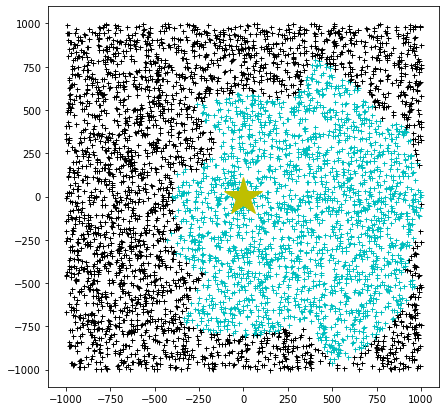

In [19]:
plt.rcParams["figure.figsize"] = (7,7)
for i in range(len(synth_data)):
    color = 'c+'
    if synth_labels[i] == 1:
        color = 'k+'
    plt.plot(synth_data[i][0],synth_data[i][1],color,markersize=5)
    
plt.plot(source_node.position[0],source_node.position[0],'y*',markersize=40)

In [20]:
# Evaluation of DFEST 
sorted_clusters = gd_fits(source_node, feat_ranges, gti_min_cluster_node, gti_feature_importance, k_prelim=10000, k_astar=1000)
sorted_solution_clusters = {}
for cluster in sorted_clusters:
    sorted_solution_clusters[cluster[1]] = cluster[0]
dfest_loss = calc_ranking_loss(ground_truth_importance, sorted_solution_clusters, d_dims)
print("DFEST Loss:",dfest_loss)

#Random Chance Evaluation
random_gti = {}
while len(random_gti) < 8: #len(solution_clusters):
    random_cluster = tuple(np.random.randint(low=-1,high=2, size=d_dims)) 
    if random_cluster not in random_gti.keys():
        random_gti[random_cluster] = np.random.randint(low=0,high=feat_range)
random_loss = calc_ranking_loss(ground_truth_importance, random_gti, d_dims)
print("Random Loss:",random_loss)

#Self Evaluation
self_loss = calc_ranking_loss(ground_truth_importance, ground_truth_importance, d_dims)
print("Self Loss:",self_loss)

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


10000 

Preliminary Search Time: 1.442655324935913 seconds

Nodes Visited: 10020
Nodes Generated: 10020


A* Cluster Search Time: 0.5750200748443604 seconds
DFEST Loss: 0.0
Random Loss: 1.125
Self Loss: 0.0


/Users/sean/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [16]:
print(gti_feature_importance)

[ 8.5  1.   2.5  5.5 14.5 11.5  4.  10.  13.   7. ]


In [2539]:
for key in sorted_solution_clusters:
    print(key,':',sorted_solution_clusters[key])

(1, 0, -1, -1, 0, 1, 0, 1, 0, 0, -1, 0, 1, -1, 0, -1, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, 0, -1, -1, 1, -1, 0, 0, 0, 0, -1, -1, 0, 0, -1, -1, 1, 1, -1, 0, 1, 0, 0, -1, 0, 0, 0, 0, 1, 0, 1, 0, 0, -1, 1, 0, 0) : 6400.000000000001
(1, 0, 0, -1, 1, -1, 0, 0, 0, 1, 1, 0, 0, 1, 0, -1, -1, 0, 1, 1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, -1, 1, -1, 0, 1, -1, -1, 0, 1, -1, -1, 1, 1, -1, 0, 1, -1, -1, 0, -1, -1, 0, -1, 0, 1, -1, -1, -1, 0, 1, -1, 0, 1, -1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, -1, 0, 1, 0) : 6799.999999999998
(1, 0, 0, -1, -1, 1, 1, 1, -1, 0, -1, 0, 0, 0, -1, -1, 0, 0, 1, 1, 0, 1, 0, 0, 0, -1, -1, -1, 0, 1, -1, 1, 0, 1, -1, 0, 0, -1, -1, 1, -1, 0, 0, 0, 1, -1, 0, 1, -1, -1, -1, 0, 1, 0, 1, -1, 0, 1, 0, 1, 1, -1, 1, 1, 0, -1, 1, -1, -1, 1, 0, 1, 1, 0, 0, -1, -1, 1, 1, 1) : 6799.999999999999
(0, 0, -1, 0, 0, -1, -1, 0, 0, 0, 0, 0, -1, -1, 1, -1, 0, 0, 1, 0, 0, -1, 0, 1, -1, 0, 0, 0, 0, -1, 0, 1, 1, 1, 1, 1, 1, -1, 0, -1, 0, -1, 1, 1, 0, 1,

(1, 0, 0, 1, 1, 1, 0, 0, -1, 1, -1, -1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 0, 0, -1, 0, 0, 0, -1, 0, 1, 0, -1, 0, 1, 0, 1, -1, -1, 0, -1, -1, 0, 1, 1, -1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, -1, 0, 0, -1, 1, -1, -1, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0) : 8800.0
(1, 1, 0, -1, 0, 0, 1, -1, -1, -1, 0, 0, -1, 1, -1, 0, -1, 1, -1, 1, 1, -1, 0, -1, -1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, -1, -1, 0, -1, 1, 0, -1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, -1, 1, -1, 1, 0, 0, 0, 1, 1, 0, -1, 0, 0, 0, -1, 0) : 8800.0
(1, -1, 0, 0, 0, 1, 0, 0, 0, 1, -1, 0, -1, -1, 0, -1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, -1, 0, 1, -1, 0, 1, 0, 0, 1, 1, -1, 1, 1, 0, 0, 1, 1, 1, 0, -1, 0, 0, 1, -1, 0, 1, 1, -1, -1, 0, 1, 1, -1, 0, 0, 1, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 1, 1, -1, 0, 0, -1, 0) : 8800.0
(0, -1, 0, 0, -1, -1, 0, -1, 0, 1, 0, 0, 1, 0, -1, -1, -1, 1, 0, -1, -1, 0, -1, 1, -1, 0, 0, 0, 1, -1, 1, 0, 1, 0, -1, 1, 0, 0, 0, 0, -1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, -1, 0, -1, -1, 1, 0, 1

(-1, 0, 1, -1, 0, 0, -1, 0, -1, 0, 0, 0, -1, 0, 1, -1, 0, 0, 0, 0, 0, 0, 1, -1, -1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 1, -1, 0, 0, 1, 0, 0, -1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, -1, 1, 0, 1, 1, -1, 1, 0, 0, 0, -1, 1) : 9199.999999999998
(0, -1, -1, 0, 0, 0, 0, -1, -1, 1, 1, 1, 0, 0, -1, 0, 1, -1, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, -1, 0, -1, 1, 0, 0, -1, 1, -1, -1, 0, -1, 0, 0, -1, 1, 0, 1, 1, 0, -1, 0, 1, -1, -1, 0, 0) : 9199.999999999998
(0, 0, 1, -1, 1, 1, 0, 0, -1, -1, 0, -1, 1, 0, -1, -1, 0, 0, 0, 1, -1, 1, 1, 1, 1, -1, 0, 0, -1, 0, -1, 1, 0, -1, 0, 1, -1, 0, -1, 0, 0, -1, 1, 1, 0, 0, 0, 1, 0, 0, -1, 1, 1, -1, 0, 0, 0, -1, 1, 0, 0, 1, 0, -1, 0, 1, 0, 1, -1, 0, 1, 0, -1, -1, 1, -1, 0, 0, -1, -1) : 9199.999999999998
(0, -1, 0, -1, 0, -1, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, -1, 0, 0, 0, 0, -1, 0, 1, 0, -1, 0, -1, 1, 0, 0, 1, -1, 0, 1, 0, -1, 0, -1, 0, 1, -1, 0, 0, 1, 0, 1, 

(1, 0, -1, -1, 0, 0, 0, 0, 1, -1, 1, 1, -1, -1, 0, 0, 0, -1, -1, -1, 0, -1, 0, -1, -1, 1, 0, 1, 0, 0, -1, 0, 1, 1, -1, 0, 0, 1, 1, 0, 0, 0, 1, 0, -1, 1, 0, 1, -1, 0, 1, -1, 0, 0, 0, 0, 1, 0, 0, -1, 0, 1, 0, -1, 0, 0, 1, -1, 0, 0, 0, 0, 0, -1, 1, -1, 0, 1, -1, 0) : 9200.0
(1, 0, 0, -1, 0, -1, 0, 1, 0, -1, 1, -1, -1, 0, 1, 1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, 1, 1, 0, -1, 0, 1, 0, -1, 0, 0, -1, -1, 0, 0, 0, 0, 1, 1, 0, 0, 1, -1, 1, 1, 1, -1, 0, -1, 0, 0, -1, -1, 1, 0, 0, -1, -1, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, -1, 0) : 9200.0
(0, 0, -1, 0, 1, 1, 0, -1, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, -1, 1, 0, 1, 0, 0, -1, 0, 0, -1, 1, -1, 0, -1, 0, 1, 0, -1, 0, 0, 0, -1, 0, 0, 1, 0, -1, 0, 0, -1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, 0, 1, 1, -1, 0, 0, 0, 1, -1, -1, 0, 0, 0, 0, 0, 0) : 9200.0
(0, 1, -1, -1, 0, 1, 1, 1, 0, 0, 0, -1, 0, -1, 0, 1, 1, 0, -1, 1, 1, 0, 0, 1, -1, 1, 1, 1, 0, -1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, -1, -1, 1, -1, 0, -1, 0, 0, -1, 0

(1, 1, 0, -1, 0, 0, 0, -1, -1, 0, -1, 0, 0, 0, 0, 0, 0, -1, 1, 0, 1, 1, 0, 0, 0, 0, -1, -1, -1, 0, 0, 1, 1, -1, -1, 0, 0, 0, 0, 1, -1, 0, 1, -1, -1, 1, 0, 0, 0, -1, 1, -1, -1, 0, -1, 1, 1, 1, -1, 0, 1, 0, 0, 0, 1, 1, 0, 0, -1, -1, 0, 0, 0, -1, 1, 0, -1, -1, 0, -1) : 9200.000000000002
(-1, 0, -1, 0, 1, 1, 0, 0, 0, 0, 0, 0, -1, 1, -1, -1, -1, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 1, 0, -1, 0, -1, -1, 1, 1, 1, 0, -1, 0, 0, 1, 1, -1, 0, 0, 0, -1, -1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, -1, 0, -1, 0, 1, 0, -1, 1, 0, 0, 0, -1, 0, 1, 0, 1, 0, 1, -1, -1, 1, 0) : 9200.000000000002
(1, -1, 0, 1, 0, 0, -1, 1, 0, 0, 1, 0, -1, 1, 0, -1, -1, 0, -1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, -1, 0, 1, 0, 1, 0, 0, 0, -1, -1, 1, 0, 1, 0, -1, 0, -1, 0, -1, 0, 0, 1, 1, -1, 1, 1, 0, 1, 1, 0, 1, -1, -1, 0, 0, 1, 1, 0, 0, 1, -1, 0, 0, 0) : 9200.000000000002
(0, 0, 0, 0, 1, 0, 0, 1, -1, 0, 0, 1, 0, 1, -1, 0, 0, -1, 0, 0, 0, 1, 1, 1, 0, 1, 0, -1, 0, -1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 1, 0, -1, 0, -1, -1, 0, 1, 0, 1

(0, -1, 0, -1, 1, -1, -1, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 1, -1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 1, 0, 1, -1, 1, 0, 1, 0, -1, 0, 1, -1, -1, 1, -1, -1, 1, -1, 0, 0, 1, 0, -1, 1, 0, -1, 0, 0, 0, 1, -1, -1, 0, 0, 0, 0) : 9600.0
(1, -1, 1, -1, 0, -1, 1, 0, 0, 1, 0, 0, 0, 0, 0, -1, 1, 0, 1, 0, 1, 0, -1, -1, -1, 0, 0, 1, 0, 0, -1, 0, 1, 0, 0, 0, 0, 1, 0, -1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 1, 0, -1, 1, -1, 0, 1, 1, 0) : 9600.0
(1, -1, -1, -1, -1, 1, -1, 0, 1, 1, -1, 0, 0, -1, 1, 0, 1, 1, 1, -1, 1, 0, -1, 0, 0, -1, 0, 1, 0, 1, 0, 0, 0, -1, 0, 0, -1, 1, 1, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 1, -1, 0, 1, -1, -1, 0, 0, 0, 0, 0, -1, 0, -1, 0, 1, -1, 0, 1, -1, 0, 0, -1, 0) : 9600.0
(1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, -1, 1, -1, 0, -1, 0, -1, 0, 0, 0, 0, 1, -1, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0, 0, -1, 1, 1, 1, 0, 1, -1, 1, 0, -1, 0, 0, 1, 0, 0, 1, -1, -1, 0, -

(0, 0, 1, 0, 0, 0, 0, 1, -1, -1, 0, 0, 1, 0, 0, 1, -1, 0, 1, 0, 0, 1, 0, 1, 0, 1, -1, 1, 1, 0, 0, 1, 0, 0, 0, -1, 0, 0, 1, 1, -1, 0, 0, 1, 0, -1, -1, 1, 0, -1, 0, 0, 1, 1, 1, 0, 1, -1, 1, 1, 1, 0, 0, 0, 1, 0, -1, 0, -1, -1, -1, 0, 0, -1, 0, 1, 1, 1, 1, 0) : 9600.0
(0, 0, 1, -1, -1, 0, 0, -1, 0, 0, 0, -1, 1, 0, 1, -1, 0, 0, 0, 0, 0, 0, -1, 1, 1, 0, 1, 0, -1, 0, 0, -1, 0, 1, 0, 0, 0, 1, 1, 0, 0, -1, 0, -1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, -1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 1, 1, 0, -1, 0, 1, 0, 0, 1) : 9600.0
(0, 0, 0, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, 1, -1, 1, 1, 0, 0, -1, 1, -1, 1, 0, -1, 1, 0, 1, -1, 0, -1, -1, 1, -1, 0, 1, 0, -1, 0, 0, 1, -1, 0, 0, 0, 1, 0, 1, -1, -1, -1, 1, -1, 0, -1, 0, 0, -1, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 1) : 9600.0
(1, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 1, 0, 1, -1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1,

(-1, 0, 1, 0, 1, -1, 0, -1, 1, 1, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, -1, 1, 0, 1, 0, 0, 0, -1, 0, -1, 0, 0, 0, 1, -1, 1, 0, 0, -1, 1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, -1, -1, -1, -1, -1, 1, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, -1, 1, 0, -1, 0, 0, 0, -1, -1, 1, 1) : 9600.000000000002
(0, -1, 0, 0, -1, 0, 0, -1, 0, 0, 0, -1, -1, 0, 0, -1, 0, 1, 0, 1, 0, -1, 0, 1, 0, 1, 0, 0, -1, -1, -1, 1, -1, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, -1, 0, 1, 0, 1, 1, -1, -1, 1, 1, 0, 1, 0, 0, -1, 0, -1) : 9600.000000000002
(-1, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, -1, -1, 1, -1, -1, 1, 0, 0, 0, 0, 1, 0, -1, 1, 0, -1, 0, 0, 0, -1, 0, 1, 0, 0, -1, 1, -1, -1, 0, -1, -1, 0, 0, -1, 0, 0, 0, -1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, -1, 0, 0) : 9600.000000000002
(1, 0, 0, 1, 0, 0, 0, -1, -1, 1, 0, -1, 1, 1, 1, 0, 1, 0, -1, -1, 0, 0, 1, 1, 0, 0, 0, 1, -1, 1, 0, 0, 0, 0, 0, 0, -1, 1, 0, 1, -1, 0, -1, 0, 0, -1, 1, -1, -

(0, 0, 0, 0, 1, 0, 0, 0, -1, 1, -1, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, -1, 0, 1, 1, 0, -1, 0, 0, 0, 1, -1, 0, 0, 1, 0, 1, 0, 0, -1, -1, 1, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, -1, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, -1, 0, 0, 1, -1, 0, -1, 1, 0) : 9999.999999999998
(0, -1, 1, 0, 1, -1, 0, -1, -1, -1, 1, 1, 1, -1, 1, 0, 0, -1, -1, 0, 0, 1, 1, 0, 0, 1, -1, 0, 0, 1, -1, 0, 1, -1, -1, 0, 0, 0, -1, 0, 0, 1, 0, -1, 1, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, -1, 0, 1, 1, 0, 1, -1, 0, 1, -1, -1, -1, 0, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 0) : 9999.999999999998
(0, -1, 0, 0, -1, -1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, -1, 1, 1, 0, 1, -1, 0, 0, -1, 0, -1, 1, 0, -1, -1, 0, 0, 0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0, 0, -1, -1, 0, 0, -1, 1, -1, -1, 1, 0, -1, 0, 1, 1, 0, -1, -1, 0, 0, -1, 1, -1, 0, 0, 0, 0, 1, 0, 0, -1, 0, 1) : 9999.999999999998
(-1, 0, 0, -1, 0, 0, -1, -1, 0, -1, 0, 0, 0, -1, -1, -1, -1, 0, 1, 0, 0, 0, -1, -1, 0, 0, -1, -1, 0, 0, 0, -1, 0, 1, 1, 0, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0

(0, 1, 0, 0, 0, -1, 0, 1, 1, 1, -1, 0, 0, 1, 0, 1, 0, -1, 1, -1, 1, 1, 0, 0, 0, 0, 0, -1, -1, 1, 0, -1, 1, 1, -1, 0, 1, -1, 0, 0, 0, 1, 0, -1, 0, -1, 0, 0, 0, 1, -1, 0, -1, 0, -1, 0, -1, 1, -1, 0, 1, -1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0) : 10000.0
(1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, -1, 0, -1, 0, -1, 0, 0, 0, -1, 0, 1, 1, -1, -1, 0, 0, 0, 1, -1, 1, 0, 0, -1, -1, 1, 1, 0, 0, 0, -1, -1, 0, 0, 0, 1, -1, 0, 1, -1, -1, 0, 1, -1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, -1, 1, 1, 0) : 10000.0
(0, -1, 0, 0, -1, 0, 0, 0, 0, -1, 1, 0, 1, 1, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, -1, 1, 0, -1, -1, 0, 1, 1, 1, 0, 0, 0, -1, -1, -1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, -1, 0, 0, 1, 1, -1, 1, 1, -1, 0, 1, -1, -1, 0, 0, -1, 1, -1, -1) : 10000.0
(0, -1, 0, 0, 1, 1, 0, 0, 0, 0, 1, -1, -1, 0, 1, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, -1, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, -1, 1, 0, 0, 0, -1, 0, 0, 1,

(0, 0, 1, 0, 1, 0, -1, 0, 1, 0, -1, 0, 0, -1, -1, -1, 0, 1, 0, 0, -1, 1, 0, 0, 1, -1, 0, 1, 1, -1, -1, 1, 0, 0, -1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, -1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, -1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, -1, 1, 0, 1, 1, 1, -1) : 10000.0
(-1, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, -1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, -1, 0, 0, -1, 0, 0, 0, 0, 1, 1, -1, 1, 0, -1, -1, 1, -1, 0, 1, 1, -1, -1, 0, 0, -1, 1, -1, 0, 0, 0, 0, 0, -1, 1, -1, -1, 0, 0, 0) : 10000.0
(0, -1, 1, 0, 1, -1, 0, 0, 0, 1, 0, 1, 0, 1, -1, 1, 1, 0, 1, -1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, -1, -1, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, -1, 0, -1, -1, -1, 1) : 10000.0
(-1, 0, 0, 0, 0, -1, -1, 0, 1, -1, 0, 0, 0, -1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, -1, 0, 1, 0, 1, -1, 1, 1, 0, 1, -1, -1, 0, -1, -1, 0, 0, -1, 0, 0, -1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, -1, 0, 1, 

(1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, -1, 1, -1, 1, -1, 0, -1, 1, 0, 0, 0, 1, 1, -1, 0, 1, -1, 1, 0, 0, -1, 0, 1, 0, 0, 0, -1, 0, -1, 0, 0, -1, 0, 1, 0, 0, 1, -1, -1, 0, 1, -1, -1, 1, 0, 0, 1, 0, 0, -1, -1, 0, 0, 0, -1) : 10000.0
(1, 0, -1, 1, -1, 0, 0, 0, 1, 0, 1, 1, 1, -1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, -1, 1, 0, -1, -1, 0, 0, 1, 1, -1, -1, 1, 0, 0, 1, 1, 0, 0, -1, -1, 0, 0, 1, 0, 0, -1, -1, 0, 0, 0, 0, -1, 1, -1, 1, 1, 0, -1, -1, 1, 0, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 0, -1, 1, -1) : 10000.0
(0, 1, 1, 0, 0, 0, -1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, -1, 1, 0, -1, -1, 1, 1, 0, 1, -1, -1, -1, -1, -1, 0, 0, 0, -1, -1, 0, -1, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 1, -1, 0, 1, 0, 0, -1, 0, -1, 1, 0, -1, 0, -1, 1, 0, -1, 0, 0, 0, -1, 1, 0, 0, 1, 1, 0, 0, -1, -1) : 10000.0
(1, -1, 0, 1, 0, 1, 0, 1, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1, -1, 0, -1, 1, 0, 0, -1, -1, 0, 0, 0, -1, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 1, 1, -1

(-1, 0, 0, -1, 0, 1, -1, 1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, -1, 1, 0, 0, 0, -1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, -1, 0, -1, 0, 0, -1, -1, 0, -1, 1, -1, 0, 0, 0, -1, -1, -1, 1, 1, -1, 0, 0, 0, 0, -1, 1, -1, -1, 0, 0, 1, 0, 0, 0, 0, -1) : 10000.0
(0, 0, -1, 0, 0, -1, -1, -1, -1, -1, 0, 1, 0, 0, -1, 0, 0, 0, 0, -1, 0, 1, 0, 0, -1, 1, 1, -1, 0, -1, 0, 0, -1, 0, 0, 0, 0, -1, 1, 0, 1, 0, 1, 1, -1, 0, 0, 0, 0, 0, 1, 1, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, -1, -1, -1, 1, 0, 1, 0, -1, 0, 0, -1, 0, -1, 0, 0, -1) : 10000.0
(0, 0, 0, 1, 0, 0, 1, -1, -1, 1, 0, 0, 1, 0, 0, -1, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0, -1, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 1, 0, 1, 1, -1, 0, 1, -1, 1, -1, 0, 0, 0, 1, -1, -1, 1, 0, -1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 1, -1, -1, 1) : 10000.0
(0, 1, 1, 0, -1, -1, 0, 1, -1, 0, -1, 0, 1, -1, 0, 0, 1, 1, 1, 0, 0, 1, -1, 1, 0, 0, 0, -1, 1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 1, -1, 0, 0, 0, 1, 1, 0, -1, 0, -1, 

(-1, 0, 1, -1, 0, -1, -1, 0, 1, -1, 0, -1, 0, 0, 0, 1, -1, 0, -1, 1, 1, 0, 0, 0, 1, 0, -1, 1, 0, -1, 0, -1, -1, 0, -1, -1, 0, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, -1, 0, -1, 0, -1, 0, 0, -1, 0, 1, 1, -1, -1, 0, 0, 1, 0, -1, 1, -1, 0, 0, 0, 0, 0, 1, -1, -1, -1, -1, -1, 1, 0) : 10399.999999999998
(0, 0, 0, -1, 0, -1, -1, 0, -1, 0, -1, -1, 1, 1, 0, 1, 1, 0, 0, 1, 1, -1, 1, 1, 1, 0, 0, -1, 0, 0, -1, 1, 0, 1, 1, 0, 0, -1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 1, -1, -1, -1, 0, 1, 0, 1, 0, -1, -1, 0, 1, 0, 0, 0, -1, 0, 0) : 10399.999999999998
(-1, 0, 1, 1, -1, 1, 1, 1, -1, 0, 1, 1, 0, -1, -1, -1, -1, 0, 1, 1, -1, 0, 0, 1, -1, 1, 0, 0, -1, 0, 0, 1, -1, 0, 1, 0, -1, 0, -1, 0, 0, 1, 0, 0, -1, 0, -1, -1, 0, 0, 0, -1, 0, -1, 0, -1, -1, -1, 1, 0, 0, 1, 1, -1, 1, -1, 0, 0, 0, 0, -1, 1, 1, 0, 0, 0, 0, 1, 0, 0) : 10399.999999999998
(-1, 1, -1, -1, 0, -1, 1, 1, 1, 0, -1, 0, -1, 1, 1, 1, 1, -1, 0, 0, -1, 0, -1, 1, 0, -1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, -1, 0, 0, 0, 

(0, -1, -1, 0, -1, 0, 1, 0, 0, 0, 0, -1, 0, 1, -1, 0, 0, 1, 0, 0, -1, 0, -1, 0, -1, 1, -1, -1, -1, 0, 0, -1, -1, 0, -1, -1, 0, -1, 1, 0, -1, 0, 1, 1, -1, 0, 0, 1, -1, 0, 0, 0, 1, -1, 0, 0, -1, 1, 1, 0, 0, 1, -1, 0, 0, 1, -1, 0, 0, 0, -1, 0, 1, 0, 0, 1, 0, 0, 1, -1) : 10400.0
(1, 1, 0, -1, 0, 1, 1, -1, 0, 0, -1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, -1, 1, 0, -1, -1, 0, 0, 1, 1, -1, 0, -1, -1, -1, -1, 0, -1, -1, 1, -1, 0, 0, 1, -1, 1, 1, -1, 0, 1, -1, 1, 0, 0, 1, -1, -1, 0, 0, 0, 1, 1, 0, -1, 0, 1, 1, 0, -1, -1, 1, 0, -1, 0, 0) : 10400.0
(1, 0, 1, -1, -1, 1, 0, -1, 0, 0, -1, 0, 1, -1, -1, 0, 0, -1, 0, 1, 1, 0, 1, -1, 0, -1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, -1, 0, 1, 0, 1, 0, 0, -1, 0, 1, 0, 0, -1, 1, -1, 1, 0, 1, -1, 0, 0, 0, -1, 0, 0, 1, 0, -1, -1, -1, 1, 0, -1, 1, 0, 1, 0, 1, 0, 1, -1, -1, 0) : 10400.0
(0, 1, 0, 0, 0, 0, 0, -1, 0, 0, 1, -1, -1, 0, 1, -1, -1, 1, 1, 0, -1, -1, 0, -1, 1, -1, 0, 0, 1, 0, -1, 1, 1, -1, 0, -1, -1, 0, -1, 0, -1, 0, 1, 0, 0, 0, 1, 0, -1, 0, 0, -1, 0, 1

(0, 0, -1, 1, -1, 1, -1, -1, -1, 1, 0, 0, 1, -1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, -1, 0, 0, -1, -1, 0, 0, -1, 0, 1, 0, -1, 1, 0, 1, -1, 0, 0, -1, -1, 0, 0, -1, 0, 1, 0, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 1, -1, -1, 0, -1, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 1, 0, 0, 0) : 10400.0
(1, 0, -1, 1, 1, -1, -1, 0, -1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, -1, 0, 0, 0, 1, 0, -1, -1, 0, 1, 1, 1, 0, -1, 1, 0, 0, 0, 0, -1, 0, 0, -1, 1, -1, 0, 0, -1, -1, 0, 0, -1, 1, 1, 0, -1, 0, 0, -1, 0, -1, 1, 1, 0, -1, -1, 0, -1, 0, 0, -1, 0, 0, 1, 1, 1, 1, -1, 0, 0, 0) : 10400.0
(-1, 0, 0, 0, 1, 0, -1, -1, -1, 0, 0, 1, 1, -1, -1, -1, 0, 1, -1, 0, 1, -1, 0, 0, 0, 0, -1, 1, -1, 1, 1, -1, 0, 1, -1, -1, 0, 1, 0, -1, -1, -1, 0, 0, 1, -1, 1, 0, -1, 0, 0, 0, 0, -1, 0, 1, -1, -1, 0, 0, 1, 0, -1, 1, 1, 0, 1, 1, 0, 0, 0, -1, 1, 0, 0, 0, 1, 0, 0, 0) : 10400.0
(1, 0, 0, -1, 1, -1, -1, 1, 1, 0, 0, 0, 0, -1, 1, 1, 1, -1, 1, 0, 0, 1, 0, -1, 1, 0, 1, 0, 0, 0, -1, 0, -1, 0, 1, 0, 0, 0, 1, 0, 1, 0, -1, 1, -1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 

(1, 0, 0, 0, 1, -1, 0, 0, 0, -1, 1, -1, 0, 0, 0, 0, 0, -1, 0, -1, -1, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, 1, -1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, -1, 0, 0, 0, 0, -1, 0, 0, -1, -1, 0, 0, 1, 0, -1, 1, -1, 1, 1, 0, 0) : 10400.0
(-1, 1, 0, 0, 1, -1, 0, 0, 1, 0, 0, -1, 1, 0, 1, 0, 0, 1, -1, -1, 0, -1, 0, 0, -1, 0, 0, 0, -1, 1, 1, 0, 0, 1, 1, 1, -1, -1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, -1, 0, -1, 0, 0, -1, 1, -1, 1, 0, 0, -1, 0, -1, -1, -1, 0, 1, 0, -1, 0, 0, -1, 0, 0, 1, 0, -1) : 10400.0
(0, -1, -1, 1, 0, 0, -1, -1, 0, -1, 0, 1, -1, 0, 0, 1, 1, 1, -1, 0, 0, -1, 1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 0, -1, -1, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, -1, -1, 1, 0, 0, 1, -1, 0, 1, 0, -1, -1, 0, -1, -1, 1, 1, 0, -1, 0, -1, 0, 0, 0, 0, -1, 1, 1, 0, -1) : 10400.0
(-1, 1, -1, 0, 0, 1, 0, 0, 0, 1, 1, -1, 0, 0, 1, 0, 0, 1, -1, 1, 0, 1, 1, 1, -1, 0, 0, -1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, -1, 1, -1, 1, -1, 1, -1, 0, 0, 0, -1, 1, 1, 0, 0, 1

(0, 0, 1, 0, 1, 0, 0, 1, -1, 0, 0, 1, 0, -1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, -1, 0, 0, 0, -1, -1, 1, 0, 1, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, -1, -1, -1, 1, 0, 0, -1, 1, 0, 1, 1, -1, 0, 0, 0, 1, -1, -1, 1, 1, 1, 0, -1, 0, 0, 0, 0, 0, 1) : 10400.000000000002
(0, 0, 1, 1, 0, 0, 1, -1, 0, 0, 0, 0, -1, -1, 0, 0, -1, 0, 0, -1, 1, 0, -1, 1, 1, -1, 1, 1, 0, 0, 1, -1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, -1, 1, -1, 0, 0, 1, 0, 1, -1, -1, 0, 0, -1, -1, -1, -1, 1, 0, 0, 0, -1, 1, 0, 1, 1, 0, -1, -1, -1, 0, 0) : 10400.000000000002
(0, 0, 1, 0, 0, -1, 0, -1, -1, 0, 1, 0, 1, -1, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, -1, 1, 0, 0, -1, 1, 0, 1, 0, 0, -1, 0, 0, 0, -1, 1, -1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, -1, 0, -1, -1, 0, -1, 0, 0, -1, 0, -1, 0, -1, 0, -1, 1, 0, 0, -1, 0) : 10400.000000000002
(1, -1, -1, -1, 1, 1, 0, 0, -1, 0, 0, 0, -1, 0, 1, 0, 1, 0, -1, -1, -1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 1, 1, -1, -1, 0, 0, -1, -1, 0, 0, -1, -1, -1

(-1, 0, 0, -1, 0, 0, 0, 1, -1, 0, 1, -1, 0, 0, -1, 0, 1, 1, 0, -1, 1, 0, 0, -1, 1, 0, -1, 0, -1, -1, 0, -1, 1, 0, 0, -1, 1, 0, 1, 0, -1, -1, 0, 0, 1, -1, 0, -1, -1, 0, 0, -1, 0, 0, 1, 0, 0, 1, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 1, -1, 1, 1, 1, 0, 0, -1, 0) : 10799.999999999998
(-1, 0, 0, 0, -1, 0, -1, 1, 0, -1, 1, 0, -1, 0, 1, 0, -1, 0, 0, -1, 1, 0, 1, -1, 0, 0, -1, 1, -1, 0, 1, -1, -1, 0, 0, 0, 1, -1, 1, 1, 1, 0, 0, 1, -1, 0, 0, 0, 0, -1, -1, 0, 1, 0, 0, 1, 0, 0, 1, -1, -1, -1, -1, 0, 1, 0, -1, 1, 0, 1, 0, 1, 0, 0, -1, -1, 1, 1, 1, 0) : 10799.999999999998
(-1, -1, -1, 1, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, -1, -1, 0, -1, 0, 0, -1, 0, 0, 1, 0, -1, 1, -1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, -1, 1, -1, 1, 0, -1, -1, 0, -1, 1, 1, 1, 1, 0, 0, 1, -1, 0, 0, 0, 0, 0, -1, 1, -1, 0, 0, 1, -1, 0, 0, 0, -1, 1, 0, -1, 1, 0) : 10799.999999999998
(0, -1, 0, 0, 1, 0, -1, 1, 0, 0, 1, 0, 1, -1, 1, 0, 1, 1, -1, 0, -1, 0, 1, -1, 0, 0, -1, 0, 1, 1, 0, 0, 1, 0, 0, -1, 0, -1, 0, 0, -1, 1, 1, 1, -1,

(1, 1, -1, 0, 0, 1, 0, -1, 0, -1, 1, 1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 1, -1, 0, -1, 1, 0, 0, 0, 1, 1, 0, -1, 0, 1, 1, 0, -1, 0, -1, 0, 0, 0, 0, 0, -1, -1, -1, 0, -1, 0, -1, 1, 1, -1, -1, 0, 1, -1, 0, -1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, -1, -1, 0, 1, 0, 0, 1, 0) : 10800.0
(0, 1, 1, 0, -1, 0, 1, 0, -1, -1, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, -1, 0, 1, 1, 0, 0, -1, 1, 1, 0, 0, -1, -1, 1, -1, 0, 1, -1, 0, 0, -1, 0, 0, -1, -1, 0, 0, 1, 1, 1, -1, 0, 0, 0, 0, -1, -1, 0, -1, -1, 0, 1, 0, 0, 1, 0, -1, 0, -1, 0, 0, 1, 0, 0, 1, 1, 0) : 10800.0
(0, 1, -1, 1, 0, -1, 1, -1, 0, 0, 0, 1, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 1, 1, -1, 1, 0, 0, -1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, -1, -1, 1, 0, -1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, -1, -1, 0, 1, -1, -1, -1, 0, 1, -1, -1, 1, -1, -1, 1, 0, 0, 1, -1, -1, -1) : 10800.0
(0, 0, 0, 0, -1, 1, 0, 0, 0, 1, -1, -1, 0, 0, -1, 1, 0, 1, 0, -1, 0, 1, 1, 0, 0, -1, 0, -1, 0, 0, -1, 0, 1, 0, -1, -1, 0, 0, 1, 1, 0, 1, 1, -1, -1, -1, 1, -1, 0, 0, 0, -1, -1, 0, 0, 0,

(1, -1, -1, -1, 1, 1, 0, 0, -1, -1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, -1, 0, -1, 0, 0, 0, 1, -1, -1, -1, 0, -1, -1, 1, -1, 0, -1, 0, 0, 1, 0, 0, -1, 0, -1, 0, -1, 1, -1, 0, 0, -1, 0, -1, 1, 0, 0, 0, -1, 0, 1, -1, 0, 0, -1, -1, 0, 0, 0, 1, 0, -1, 0, -1, 0, 0, 0, -1, -1) : 10800.0
(-1, 0, 1, -1, -1, 0, -1, 1, 0, 0, -1, -1, -1, 0, 1, -1, -1, 1, -1, 0, 1, 1, -1, 1, -1, 0, 0, 1, 0, -1, 1, -1, -1, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 1, -1, -1, 1, 1, 0, 1, 0, 1, 1, 0, 0, -1, 0, -1, 0, 1, 1, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0) : 10800.0
(1, 0, 1, 0, -1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, -1, 1, 0, 0, 0, 0, 0, 0, -1, -1, 0, -1, 0, 1, -1, -1, -1, 0, -1, 1, 0, 0, -1, 0, 0, 0, 0, 0, 1, -1, 1, 1, 0, -1, -1, 0, 0, -1, 1, 1, 0, 0, 1, 1, -1, 0, 1, 1, 0, -1, -1, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 1, -1, 1, 1) : 10800.0
(-1, 0, 1, 0, -1, -1, -1, 1, -1, 0, 0, -1, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, -1, 0, 0, -1, -1, -1, 1, -1, -1, 0, -1, 0, 1, -1, -1, 1, 0, 1, 1, -1

(-1, 0, -1, 0, 1, 0, 0, -1, 1, -1, -1, 0, 0, 0, 1, 0, 1, 0, 0, 0, -1, 0, 0, 1, 0, -1, 1, 0, -1, 1, 1, 1, -1, 1, 0, -1, 1, -1, 1, 0, 1, -1, 1, 0, 0, 0, 0, 1, -1, 1, -1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, -1, 1, 0, -1, 0, 0, 0, 0, -1, 0, 1, -1, -1, 0) : 10800.0
(0, 1, 1, -1, -1, -1, 0, 0, 0, 1, -1, -1, -1, 1, 0, 1, 0, 0, 1, -1, 0, 1, -1, 1, 0, 1, 1, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, -1, -1, -1, 1, 1, 0, 0, 1, -1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, -1, 1, 0, 0, 0, -1, 1, 0, -1) : 10800.0
(0, -1, 0, 0, -1, 1, 0, 0, 0, 0, -1, -1, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1, -1, 0, 1, 0, 0, 0, 0, -1, 1, 0, -1, 0, -1, 0, 0, -1, 0, 0, 0, -1, -1, 1, 0, 1, 0, 0, 1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 0, -1, 1, 0, 1, -1, 0, 0, 0, -1, 1, 1, 0, -1, -1, 0, 0, 1, -1) : 10800.0
(0, 0, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 0, -1, -1, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, -1, 0, 1, 0, 0, -1, -1, 1, -1, 0, 1, 0, 0, 0, 0, 0, -1, 0, -1, 0, -1, -1,

(0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 1, 1, 1, 0, -1, 0, -1, 0, 0, 0, -1, 0, 0, -1, 0, -1, 0, 0, 1, 0, 1, 0, 0, -1, -1, 0, -1, 1, 0, 1, -1, -1, -1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 1, 1, 0, 1, 1, 0, -1, -1, -1, -1, 1, 1, 1, 1, 0, 0, -1, -1, 0, 0, 0, 0) : 10800.000000000002
(0, 1, -1, 1, 1, -1, -1, -1, 0, 1, 0, 0, 1, 0, -1, 0, -1, 0, -1, 0, 0, 0, 1, 0, 0, 0, -1, 0, -1, 0, 1, 0, 0, 0, 1, -1, 1, 0, 0, -1, 0, -1, -1, 0, 0, -1, 1, 0, 0, 1, 1, -1, 0, 1, 0, 1, 1, 0, -1, 1, 0, 1, 0, 0, 0, -1, 0, 1, 0, -1, 0, 1, 0, 0, 1, 0, 0, 1, 0, -1) : 10800.000000000002
(0, 0, 0, 0, 0, -1, 1, 0, 0, -1, 1, 1, 1, 0, 0, -1, -1, 0, 0, -1, -1, -1, -1, 0, 0, -1, 1, -1, -1, -1, 0, 1, 0, 0, 0, 0, 1, 1, 1, -1, 0, -1, 0, 0, 1, -1, 0, 0, 1, 0, 1, 0, -1, 0, -1, 1, 0, 0, -1, 0, 0, -1, 0, 0, -1, 0, 0, -1, 1, 1, 1, 1, 0, -1, 0, 1, 1, -1, -1, 0) : 10800.000000000002
(0, 0, 0, 0, 0, -1, 1, -1, 1, 0, 1, -1, -1, 0, 0, 0, 0, 1, 0, 0, 1, 0, -1, 0, 0, 0, 1, -1, 0, 0, 0, 0, 1, 0, 1, 0, 0, -1, 0, 0, -1, 0, -1, 0, 1, 1, 0, 

(1, 1, 0, 0, 0, 1, 1, 0, -1, 0, -1, 0, -1, 0, -1, -1, 0, 1, 1, 0, -1, 1, 1, 0, 1, 0, -1, 1, 1, 1, 1, 0, -1, 1, -1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, -1, 0, 0, 0, 0, 1, -1, 0, -1) : 11199.999999999998
(1, 1, 0, 0, -1, 0, 0, 1, 0, -1, 0, 0, 0, 1, 0, -1, 0, 0, 1, 0, -1, -1, 0, -1, 0, -1, -1, 1, 0, 1, -1, 0, 1, 0, 1, -1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, -1, 0, 0, 0, 0, 0, -1, 1, 0, -1, 1, 0, 1, -1, 1, 0, 0, 0, -1, 0, -1, -1, 1, 0) : 11199.999999999998
(0, -1, 0, 1, 1, 0, -1, 0, -1, 1, 0, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 0, 1, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 1, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, -1, -1, 0, -1, 1, 0, 0, 0) : 11199.999999999998
(0, 0, 1, 0, -1, 0, 1, 0, 0, -1, 1, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 1, 1, -1, -1, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,

(0, 0, 1, -1, 0, -1, 1, 1, 0, 1, 0, 1, 0, -1, 0, 0, -1, 0, -1, 1, 0, 1, -1, 0, 0, -1, -1, 1, -1, 0, -1, 1, -1, 0, -1, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, -1, 0, -1, 0, 0, 1, 0, -1, -1, 0, 0, 0, 0, 0, -1, 0, -1, 1, 1, 1, -1, 1, -1, 1, 0, 1, 0, 0, 1, 0, -1, 0, -1, 0) : 11200.0
(1, -1, -1, 0, 0, -1, 0, 1, 1, -1, 1, 0, -1, 1, -1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, -1, -1, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, -1, 1, -1, -1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, -1, 1, -1, -1, 0, 0, 0, 1, 1, -1, 0, -1, 0, 0) : 11200.0
(0, 1, 0, 1, 0, 0, 1, 0, -1, 1, 0, 0, 0, 1, 1, 1, 0, -1, 1, 0, -1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, -1, -1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, -1, -1, 1, 0, 0, -1, 0, 1, 0, 1, -1, -1, 0, -1) : 11200.0
(0, 1, 0, -1, -1, 0, 0, 0, -1, 0, 1, 1, 1, -1, 0, 1, 1, 1, 1, -1, 0, -1, -1, 0, 1, 0, 1, 0, 0, -1, 0, -1, 1, 0, 0, -1, 0, -1, 1, -1, 1, 1, 0, 1, 0, 0, 0, -1, 0, 1, 1, -1, 0, 0, 0, 0, 1, 0, 

(0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, -1, 0, 1, -1, 0, 0, 1, -1, 0, 0, 0, 1, 0, 0, 0, 0, -1, 1, 1, 1, 0, 0, 1, 1, 0, -1, -1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, -1, 1, -1, 0, 1, 0, 1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0) : 11200.0
(1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 1, 0, -1, 0, -1, 0, 0, -1, 1, 1, 1, 0, -1, 0, 1, 1, 1, 0, 1, -1, 0, 0, -1, 0, -1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 0, -1, 0, -1, -1, 0, 0, -1, 0, 0, 0, 1, -1, -1, 0, 0, 0, 0, -1, 1, 0, 1, 0) : 11200.0
(1, -1, -1, 1, 1, 0, 1, -1, 0, 0, 0, 0, 0, 0, 1, -1, -1, 0, 1, 0, -1, 0, 0, -1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, -1, 1, -1, -1, 1, 0, -1, 0, 0, 1, -1, 0, 1, -1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, -1, 0, -1, -1, 1, 0, -1, -1, 0) : 11200.0
(0, 1, -1, 0, 0, -1, 1, 1, 1, 1, 1, 1, 1, 0, 1, -1, -1, -1, 0, 0, 1, -1, -1, 0, 0, 0, -1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, -1, 1, 0, -1, 

(0, -1, -1, 1, 0, -1, 1, -1, 0, -1, -1, 1, 0, -1, -1, 0, 0, 0, 1, 0, -1, 1, 0, -1, 0, 0, 1, 0, 1, 1, -1, -1, -1, -1, 0, -1, 0, -1, 0, 0, 1, -1, 0, 0, 0, -1, 1, 0, 1, 1, 1, 0, 1, 0, -1, 1, 0, 0, 0, 1, -1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 1, -1, 0, -1, 1, 0, -1) : 11599.999999999998
(1, 0, -1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, -1, 0, 0, 0, -1, 0, 0, 1, 0, 1, -1, 1, 1, 0, 0, 0, -1, 1, 0, 1, 0, -1, -1, -1, 1, -1, 1, 0, 0, 0, -1, 1, 0, 1, 0, -1, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, -1, 0, -1, 0, 0, 0, 1, 0, 1, 0, -1, -1, 0, 0, 1, 0, 0, 0, 0, 1) : 11599.999999999998
(0, 0, 1, 1, 1, 0, 1, -1, 0, 1, -1, -1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, -1, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 1, 0, -1, -1, 0, -1, 0, 1, -1, 0, 0, -1, 0, 0, 1, -1, 1, 1, 1, 0, 0, -1, 0, 1, -1, 1, 1, 0, -1, 0, -1, 1, 0, -1, 1, -1, 0, -1, 0, -1, 1, -1, -1, 1, 0, 1, 0) : 11599.999999999998
(0, 0, 0, 1, 0, 1, -1, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1, 0, -1, 0, 0, 0, 1, -1, 1, -1, -1, 1, 1, 0, 0, 1, -1, 0, 0, -1, 0, 1, 1, 0, 1, 1, -1, 1, 0, -1, 

(0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, -1, 1, 0, 1, 1, 0, 1, 0, 0, -1, -1, 1, 0, 1, 1, -1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, -1, -1, 1, -1, 0, 0, 0, -1, 0, -1, 0, -1, 1, 0, 0, 1, -1, -1) : 11600.0
(0, -1, 0, 1, -1, -1, -1, 0, -1, -1, 0, -1, -1, 0, 1, 0, -1, 0, 0, 0, 0, -1, -1, 1, 0, -1, 0, 0, 1, 1, 0, -1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, -1, -1, 0, -1, -1, 0, 1, -1, 1, 0, -1, 0, -1, 0, 0, 0, 1, 1, 0, 1, 0, 0, -1, 1, 1, 0, 1, -1, 0, 0, -1, 0, -1, 1, 0, 0, 0, 1) : 11600.0
(-1, -1, 0, 1, 1, 1, 1, -1, 1, 0, 1, 0, 1, 0, 1, -1, 0, -1, 1, -1, 0, 0, -1, -1, -1, 1, 0, 0, 1, 1, 1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 0, -1, -1, 1, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, -1, 1, 0, 1, 1, 1, 1, 0, -1, 0, 1, 1, 0, 1, -1, 1, -1, 0, -1, 0, 1, 1, 0, 0, 0) : 11600.0
(1, 1, -1, 1, 0, 1, 0, -1, 1, 1, 1, -1, 0, 1, 1, -1, 0, -1, 0, 1, 0, 1, -1, 1, 1, -1, -1, 1, 1, 0, 0, 0, 0, -1, 1, 0, -1, 0, 1, -1, -1, -1, -1, 1, 1, 0, 0, -1, -1, 0, -1, 0, 1, 0, 0, -1, 

(0, 0, 1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 1, 1, 0, -1, 1, 0, 1, 0, 1, 0, 1, 0, 1, -1, -1, 0, 1, -1, 1, 1, 1, 1, 0, 0, 0, -1, 0, 0, 0, -1, 0, -1, -1, 0, 0, 0, 1, -1, 0, 1, -1, 1, -1, 0, 0, 1, -1, -1, -1, 0, -1, 0, -1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, -1, 1, 0, -1, -1) : 11600.000000000002
(-1, -1, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, 1, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 1, 0, 0, 0, 1, -1, 0, 1, 0, -1, 1, 0, -1, 1, 1, 0, 0, -1, 0, 0, 0, 0, 1, -1, 1, 0, -1, 1, 1, 0, -1, 0) : 11600.000000000002
(-1, -1, 0, -1, 0, 0, 0, -1, 1, 0, -1, 0, 1, 0, 0, 0, 1, -1, 0, 1, 0, 1, 0, 0, -1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 1, 0, 1, 1, -1, 0, 0, 0, 0, 0, 0) : 11600.000000000002
(0, -1, 0, 0, -1, 0, -1, 0, 1, -1, 1, 0, 1, 0, 0, 1, 1, -1, 0, 1, 0, 1, -1, 1, 1, 0, 1, 0, 1, 0, -1, 0, 0, 0, -1, 0, 1, 1, 0, 0, 1, 0, 1, 0, -1, -1, 1, -1, -1, 0

(1, -1, 1, 1, -1, 1, 0, 0, 0, 0, 1, -1, 0, -1, -1, 1, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, -1, 1, -1, 0, -1, -1, 1, 0, 0, 1, -1, 0, 0, -1, 1, -1, 1, 0, -1, 0, -1, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 1, 1, 1, 1, -1, 0, 0, 0, -1, 0, 0, 0, -1) : 12000.0
(-1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, -1, 0, 0, -1, 1, 0, 1, 0, -1, -1, 0, 1, 1, 0, 1, 1, 0, -1, 0, -1, 1, 0, 1, 0, 0, 1, 0, 0, -1, -1, 0, 0, 0, 0, 0, 1, 0, -1, 1, 0, 0, -1, 1, 1, -1, 1, -1, -1, -1, 1, 0, -1, 0, 0, -1, -1, 0, 1, 0, 0, -1, 1, -1, 1) : 12000.0
(1, 0, -1, 0, 0, -1, -1, 0, 1, 0, 1, 0, 0, 0, 1, 1, -1, 0, 0, 0, 0, 0, -1, 0, -1, -1, 1, 1, -1, -1, 1, 1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, -1, -1, -1, 0, 1, 1, -1, -1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, -1, 0, -1, 0, 0) : 12000.0
(1, 1, 0, 0, 1, 1, -1, 1, -1, -1, 1, 1, 0, 0, 1, 1, -1, 1, 0, 0, 0, 1, 0, 1, -1, -1, 0, 1, -1, 0, 1, -1, 0, -1, 1, -1, -1, 0, -1, 0, 0, 1, 0, -1, 0, 1, -1, 0, 0, 1, 0, -1, -1, 0, 0, 0,

(1, 0, 1, 0, 0, -1, 0, 1, 1, 1, 0, 0, -1, 0, 0, 0, 1, 1, 0, -1, -1, 1, -1, -1, 0, -1, -1, 1, 0, 0, -1, -1, 1, -1, -1, 0, -1, -1, 0, 0, 0, 1, -1, 1, 0, -1, 0, -1, 1, 1, 0, 0, 1, 0, 0, 0, -1, 1, 1, -1, -1, -1, -1, -1, 0, 1, 0, 1, -1, -1, 0, -1, 0, 0, 0, 0, -1, 0, 1, 1) : 12399.999999999998
(0, 1, 0, -1, 0, 0, 0, 0, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 0, 1, -1, 0, 1, -1, -1, 1, 0, 0, 1, 1, 1, 0, 1, -1, 1, 0, 1, 0, -1, 0, 0, 0, 1, 0, -1, 0, 1, 0, 1, 0, -1, 1, -1, 1, 0, 0, 0, -1, 0, -1, 0, 1, 0, 0, -1, 0, 0, -1, -1, -1, 0, -1, 0, 0, -1, 0, 0, 0) : 12399.999999999998
(-1, 1, 0, -1, 0, -1, 1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, -1, -1, -1, 1, 0, 1, 1, -1, 0, 1, 0, 0, 1, -1, 1, 0, 1, -1, -1, 0, 1, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, -1, 0, 0, -1, 0, 1, 1, 0, 1, -1, -1, 0, 0, 0, 0, -1, 1, 0, 1, 0, -1, -1, 0, 1) : 12399.999999999998
(0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, -1, 1, -1, 1, 0, 0, -1, -1, 1, 1, 1, 0, -1, 0, -1, 1, 1, 1, 0, -1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 

In [2513]:
for key in ground_truth_importance:
    print(key,':',ground_truth_importance[key])

(0, -1, 0, -1, 0, -1, 0, 0, -1, 1, 1, 1, 0, -1, 0, 1, -1, 0, 1, -1, 0, 0, -1, -1, -1, 0, 0, -1, 0, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 0, -1, 0, 0, 1, -1, 1, 0, 0, -1, 0, -1, 0, -1, -1, 1, 0, 0, -1, 0, -1, -1, 1, -1, 0, 0, 1, -1, 1, 1, 0, 0, -1, 0, 0, 0, -1, 0, -1, -1, 1) : 100.0
(0, 0, 0, -1, 0, -1, 0, 0, -1, 1, 1, 1, 0, -1, 0, 1, -1, 0, 1, -1, 0, 0, -1, -1, -1, 0, 0, -1, 0, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 0, -1, 0, 0, 1, -1, 1, 0, 0, -1, 0, -1, 0, -1, -1, 1, 0, 0, -1, 0, -1, -1, 1, -1, 0, 0, 1, -1, 1, 1, 0, 0, -1, 0, 0, 0, -1, 0, -1, -1, 1) : 100.83682008368201
(0, 1, 0, -1, 0, -1, 0, 0, -1, 1, 1, 1, 0, -1, 0, 1, -1, 0, 1, -1, 0, 0, -1, -1, -1, 0, 0, -1, 0, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 0, -1, 0, 0, 1, -1, 1, 0, 0, -1, 0, -1, 0, -1, -1, 1, 0, 0, -1, 0, -1, -1, 1, -1, 0, 0, 1, -1, 1, 1, 0, 0, -1, 0, 0, 0, -1, 0, -1, -1, 1) : 101.67364016736401
(0, -1, 0, -1, 0, 0, 0, 0, -1, 1, 1, 1, 0, -1, 0, 1, -1, 0, 1, -1, 0, 0, -1, -1, -1, 0, 0, -1, 0, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 0, 

In [2480]:
#Finds where top solutions in ktop_ground_truth_importance were placed by DFEST
for key_gti in ground_truth_importance:
    i=0
    for key_dfest in sorted_solution_clusters:
        if key_dfest == key_gti:
            print(i)
        i+=1

TODO:
-
- Synthetic model should have continuous importance between features
- How to push GD-FETS adj neighbor search out of cluster when it is satisfied --> promote moving into space of adjacent feature-interaction cluster instead of redundantly showing density of feature-interactions in optimal cluster... A* should be able to identify optimal feature-interaction clusters given a high LR, to essentially walk down adjacent feat-int clusters
- A* Cluster search should redundantly look at small neighborhood distributed in cluster, and search each of them downward, saving the solution node that gives the smallest distance
- synthetic model that creates a smooth & continuous decision boundary between feature interactions
- Use mean of solutions in clusters as measure of feature stability?
- Implement LIME/SHAP to give comparison of their performance using a Ground Truth decision boundary, to that of GD-FETS
- Implement one-way feature-interaction for GD-FETS for direct comparison to LIME
- T-tests to demonstrate signifiance of GD-FETS identifying the same feature interactions as expreesed in the GT explanation --> Only shortest distance is logical, as the average would be impacted by search bias artefacts... can show this once solutions hug the decision boundary in each solution cluster

----
- Adjust abstract to provide brief intro on importance of deep recsys/DNN explainability, followed by a majority of key features of GD-FETS
- Describe evaluation methodology in manuscript, and describe results
- Would like to do: Use T-SNE to project categorical embedding vectors from 4 dimension to 2 (reduce complexity of search space), can also collapse the dimensionality to a single dimension, although => information loss
- Use generators to dynamically create one-hot encoding labels for training embedding inversion models, for features with very large dictionary sizes, due to memory constraints
- Future Direction: Implement reinforcement learning agent to repalce the A* search engine, as RL policy can learn the most common explanability for a given model and feature values, which can be leveraged fro search.

Prev:
-
- Generate Ground Truth (GT) evaluation model with manufactured decision boundary surrounding source node, to provide a GT of explainability as defined by the function that creates the search space. This function will be used to compare the accuracy of GD-FETS to LIME. It should build the decision boundary given input parameters of which feature interactions should have what degree of instability.
- Set limit of q solutions found per multi-way feature interaction, after finding k solutions with high learning rate
- find_adjs() to take certain step size based on learning rate
- Reject the generation of an adjacent node if it is too close to an existing solution, such that local maxima aren't overrepresented, giving a chance to find global maxima for a given feature-interaction cluster
- Implement solutions clustering method for identifying which multi-way feature interaction a sample is expressing
- Implement method to display the magnitude of instability for top-k feature interactions
- Use 2-3 Std devs of each feature of training data as feat_range for data distribution to ignore outliers that would cause certain features to be traversed with too large a step size

Rejected Ideas
-
- Set limit of k solutions found per multi-way feature interaction, such that after k solutions in a single feature-interaction cluster are found, every node in the priority queue that is a member of that cluster is removed, so that only other feature-interaction clusters are searched. =>  > k*(top_n_feat_ints_desired) must be identified --> How else to prevent the overwelming redundance of the single closest feature interaction in explaining a recommendation/prediction? --> Answer: larger learning rate s.t. more areas are covered, but this leads to less specificity near decision boundary of optimal positions
- Modify find_adjs() to only generate adjacents in direction of source node, to reduce memory complexity of frontier priority queue